<a href="https://colab.research.google.com/github/VinamraOberoi/PSO-algorithm-for-DTIoV/blob/main/PSO_algorithm_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Running PSO with 10 particles...
Optimal Fitness for 10 particles: 156.58338979274615 with w1=0.01, w2=0.99

Running PSO with 30 particles...
Optimal Fitness for 30 particles: 5.464350243143357 with w1=0.00, w2=1.00

Running PSO with 50 particles...
Optimal Fitness for 50 particles: 232.74894043270373 with w1=0.02, w2=0.98

Running PSO with 100 particles...
Optimal Fitness for 100 particles: 28.22732915279426 with w1=0.00, w2=1.00


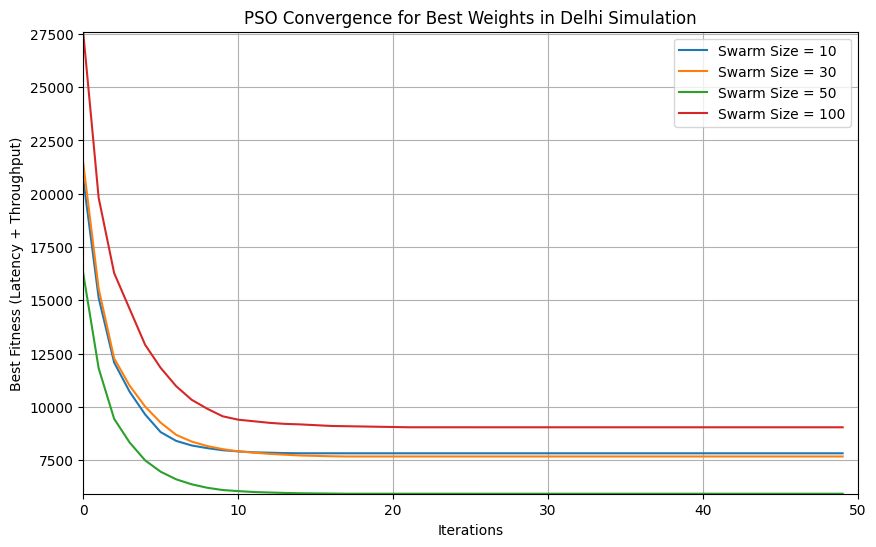

Best Weights for 10 particles: w1=0.01, w2=0.99
Best Weights for 30 particles: w1=0.00, w2=1.00
Best Weights for 50 particles: w1=0.02, w2=0.98
Best Weights for 100 particles: w1=0.00, w2=1.00
Map saved as delhi_iot_map.html


In [2]:
import numpy as np
import random
import geopandas as gpd
from shapely.geometry import Point
import folium
import matplotlib.pyplot as plt

# Load Delhi boundaries
geojson_file = 'delhi_boundary.geojson'
delhi_gdf = gpd.read_file(geojson_file)
delhi_polygon = delhi_gdf['geometry'].values[0]

def generate_random_points_within_polygon(polygon, num_points):
    points = []
    minx, miny, maxx, maxy = polygon.bounds
    while len(points) < num_points:
        random_point = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if polygon.contains(random_point):
            points.append([random_point.y, random_point.x])
    return points

# Generate datasets
num_vehicles = 1000
num_rsus = 100
num_mbs = 20

delhi_streets_grid = {
    "Vehicle_Locations": generate_random_points_within_polygon(delhi_polygon, num_vehicles),
    "RSU_Locations": generate_random_points_within_polygon(delhi_polygon, num_rsus),
    "MBS_Locations": generate_random_points_within_polygon(delhi_polygon, num_mbs),
    "Cloud_Location": [28.6139, 77.2090]
}

# PSO Parameters
num_iterations = 50
swarm_sizes = [10, 30, 50, 100]
w = 0.5  # Inertia weight
c1 = 1.5  # Cognitive parameter
c2 = 1.5  # Social parameter

# System Parameters
num_tasks = len(delhi_streets_grid['Vehicle_Locations'])
num_options = 4  # Task allocation choices: 0=Local, 1=RSU, 2=MBS, 3=Cloud
task_sizes = np.random.uniform(0.5, 5, num_tasks)
task_latencies = np.random.uniform(10, 100, num_tasks)

def calculate_distance(coord1, coord2):
    return np.sqrt((coord1[0] - coord2[0]) ** 2 + (coord1[1] - coord2[1]) ** 2)

def compute_latency(position):
    total_latency = 0
    for i, allocation in enumerate(position):
        vehicle_location = delhi_streets_grid["Vehicle_Locations"][i % len(delhi_streets_grid["Vehicle_Locations"])]
        if allocation == 0:  # Local processing
            total_latency += 10
        elif allocation == 1:  # RSU processing
            rsu_location = random.choice(delhi_streets_grid["RSU_Locations"])
            distance = calculate_distance(vehicle_location, rsu_location)
            total_latency += 30 + distance
        elif allocation == 2:  # MBS processing
            mbs_location = random.choice(delhi_streets_grid["MBS_Locations"])
            distance = calculate_distance(vehicle_location, mbs_location)
            total_latency += 50 + distance
        elif allocation == 3:  # Cloud processing
            cloud_location = delhi_streets_grid["Cloud_Location"]
            distance = calculate_distance(vehicle_location, cloud_location)
            total_latency += 100 + distance
    return total_latency

def compute_throughput(position):
    total_throughput = 0
    for i, allocation in enumerate(position):
        task_size = task_sizes[i]
        if allocation == 0:
            total_throughput += task_size / 10
        elif allocation == 1:
            total_throughput += task_size / 30
        elif allocation == 2:
            total_throughput += task_size / 50
        elif allocation == 3:
            total_throughput += task_size / 100
    return total_throughput

def fitness_function(position, w1=0.5, w2=0.5):
    latency = compute_latency(position)
    throughput = compute_throughput(position)
    return w1 * latency + w2 * (1 / throughput)

def run_pso(num_particles, w1, w2):
    particles_position = np.random.randint(0, num_options, size=(num_particles, num_tasks))
    particles_velocity = np.random.uniform(-1, 1, (num_particles, num_tasks))
    personal_best_position = np.copy(particles_position)
    personal_best_fitness = np.inf * np.ones(num_particles)
    global_best_position = None
    global_best_fitness = np.inf
    
    best_fitness_per_iteration = []

    for iteration in range(num_iterations):
        for i in range(num_particles):
            current_fitness = fitness_function(particles_position[i], w1, w2)
            if current_fitness < personal_best_fitness[i]:
                personal_best_fitness[i] = current_fitness
                personal_best_position[i] = np.copy(particles_position[i])
            if current_fitness < global_best_fitness:
                global_best_fitness = current_fitness
                global_best_position = np.copy(particles_position[i])
        
        best_fitness_per_iteration.append(global_best_fitness)

        for i in range(num_particles):
            r1, r2 = np.random.rand(num_tasks), np.random.rand(num_tasks)
            particles_velocity[i] = (w * particles_velocity[i] +
                                     c1 * r1 * (personal_best_position[i] - particles_position[i]) +
                                     c2 * r2 * (global_best_position - particles_position[i]))
            particles_position[i] = particles_position[i].astype(float) + particles_velocity[i]
            particles_position[i] = np.clip(np.round(particles_position[i]), 0, num_options - 1).astype(int)

    return global_best_position, global_best_fitness, best_fitness_per_iteration

# Run PSO for multiple swarm sizes and random weights
fitness_history = {}
best_w1_w2 = {}

for num_particles in swarm_sizes:
    best_fitness = np.inf
    best_w1 = None
    best_w2 = None
    
    print(f"\nRunning PSO with {num_particles} particles...")
    
    # Try 50 random combinations of w1 and w2
    for _ in range(50):
        w1 = np.random.random()
        w2 = 1 - w1
        global_best_position, global_best_fitness, best_fitness_per_iteration = run_pso(num_particles, w1, w2)
        
        if global_best_fitness < best_fitness:
            best_fitness = global_best_fitness
            best_w1 = w1
            best_w2 = w2
    
    fitness_history[num_particles] = best_fitness_per_iteration
    best_w1_w2[num_particles] = (best_w1, best_w2)
    print(f"Optimal Fitness for {num_particles} particles: {best_fitness} with w1={best_w1:.2f}, w2={best_w2:.2f}")

# Plotting the PSO results
plt.figure(figsize=(10, 6))

# Plot for each swarm size
for num_particles in swarm_sizes:
    # Ensure there's valid data in fitness_history for this swarm size
    if len(fitness_history[num_particles]) > 0:
        plt.plot(range(num_iterations), fitness_history[num_particles], label=f'Swarm Size = {num_particles}')
    else:
        print(f"No data for Swarm Size = {num_particles}")

# Adjust the axes limits for better scaling if necessary
plt.xlim([0, num_iterations])
plt.ylim([min(min(fitness_history[p]) for p in swarm_sizes), max(max(fitness_history[p]) for p in swarm_sizes)])

plt.title('PSO Convergence for Best Weights in Delhi Simulation')
plt.xlabel('Iterations')
plt.ylabel('Best Fitness (Latency + Throughput)')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Print the best weights for each swarm size
for num_particles, (w1, w2) in best_w1_w2.items():
    print(f"Best Weights for {num_particles} particles: w1={w1:.2f}, w2={w2:.2f}")

# Create a map of Delhi with IoV components
m = folium.Map(location=[28.6139, 77.2090], zoom_start=11)

for coord in delhi_streets_grid["Vehicle_Locations"][:100]:  # Plot first 100 vehicles for clarity
    folium.CircleMarker(
        location=coord,
        radius=2,
        popup="Vehicle",
        color='blue',
        fill=True
    ).add_to(m)

for coord in delhi_streets_grid["RSU_Locations"]:
    folium.Marker(
        location=coord,
        popup="RSU",
        icon=folium.Icon(color='green', icon='signal', prefix='fa')
    ).add_to(m)

for coord in delhi_streets_grid["MBS_Locations"]:
    folium.Marker(
        location=coord,
        popup="MBS",
        icon=folium.Icon(color='red', icon='broadcast-tower', prefix='fa')
    ).add_to(m)

folium.Marker(
    location=delhi_streets_grid["Cloud_Location"],
    popup="Cloud Server",
    icon=folium.Icon(color='purple', icon='cloud', prefix='fa')
).add_to(m)

m.save("delhi_iot_map.html")
print("Map saved as delhi_iot_map.html")
